In [1]:
'''
This will be an implementation of music genre classification using a simple Dense Neural Network.
This model will serve as a baseline to determine how well the GNN performs compared to 
current standard implementation of genre classification.

Large portions of the code have been adapted from:
https://www.clairvoyant.ai/blog/music-genre-classification-using-cnn

^ Some small adjustments made to existing code (fine-tuning; changing dropout, epoch count, etc.)

Other resources used for understanding common approaches and ideas:
https://ieeexplore.ieee.org/document/10127554


'''

'\nThis will be an implementation of music genre classification using a simple Dense Neural Network.\nThis model will serve as a baseline to determine how well the GNN performs compared to \ncurrent standard implementation of genre classification.\n\nLarge portions of the code have been adapted from:\nhttps://www.clairvoyant.ai/blog/music-genre-classification-using-cnn\n\n^ Some small adjustments made to existing code (fine-tuning; changing dropout, epoch count, etc.)\n\nOther resources used for understanding common approaches and ideas:\nhttps://ieeexplore.ieee.org/document/10127554\n\n\n'

In [9]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
# import pickle

import librosa
import librosa.display
import IPython
from IPython.display import Audio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# import tensorflow as tf
# from tensorflow import keras


In [10]:
import tensorflow as tf
from tensorflow import keras
# from keras.models import Sequential

In [11]:
df = pd.read_csv('Data/features_3_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [12]:
df.shape

(9990, 60)

In [13]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [14]:
# Drop the filename column
df = df.drop(labels='filename', axis=1)

In [15]:
# Load example audio recording
audio_file = 'Data/genres_original/pop/pop.00019.wav'
data, sr = librosa.load(audio_file)

IPython.display.Audio(data, rate=sr)

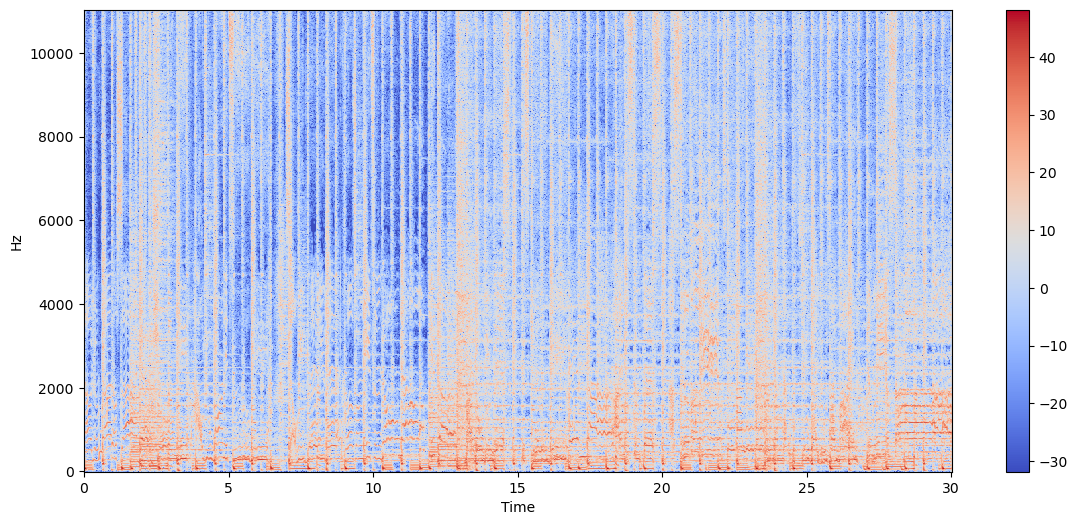

In [16]:
# View Spectrogram - represents signal loudness over time at various frequencies
stft = librosa.stft(data) # data being the audio_file loaded from above
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [17]:
# Feature Extraction
genres_list = df.iloc[:, -1] # Get last column, which has the genre labels
encoder = LabelEncoder()

y = encoder.fit_transform(genres_list) # convert to numeric representation
y

array([0, 0, 0, ..., 9, 9, 9])

In [18]:
# Scale Features and Standardize them

fit = StandardScaler()
X = fit.fit_transform(np.array(df.iloc[:, :-1], dtype=float))
X

array([[ 0.        , -0.48780784,  0.64052047, ..., -0.51356204,
         0.12841417, -0.29178072],
       [ 0.        , -0.40314187,  0.13183473, ...,  1.01138445,
         1.27578001,  0.05642464],
       [ 0.        , -0.36169428,  0.7644909 , ..., -0.04624405,
         0.65390663, -0.52145798],
       ...,
       [ 0.        , -0.35433044,  0.42997426, ..., -0.15370124,
         0.11765485, -0.33882395],
       [ 0.        ,  0.0883611 , -0.00630133, ..., -0.72456977,
         0.30333409, -0.95893743],
       [ 0.        , -0.11321002,  0.19536324, ..., -0.37245283,
        -0.47495901, -0.55112155]])

In [19]:
# Make Train-Test splits
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3)
print('X_train len: ', len(X_train))
print('y_train len: ', len(y_train))

X_train len:  6993
y_train len:  6993


In [20]:
# DNN work - training model
def trainDNN(model, epochs):
    batch_size = 128

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics='accuracy'
        )
    
    return model.fit(
        X_train, 
        y_train, 
        validation_data=(X_test, y_test), 
        epochs=epochs, 
        batch_size=batch_size,
        verbose=5
        )

In [25]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(10, activation='softmax'), # Final output layer
])

model_hist = trainDNN(model=model, epochs=50)


Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


In [26]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

94/94 [==============================] - 0s 585us/step - loss: 0.3656 - accuracy: 0.9076
Test Loss: 0.36560145020484924
Test Accuracy: 0.9075742363929749


Validation Accuracy 0.9125792384147644


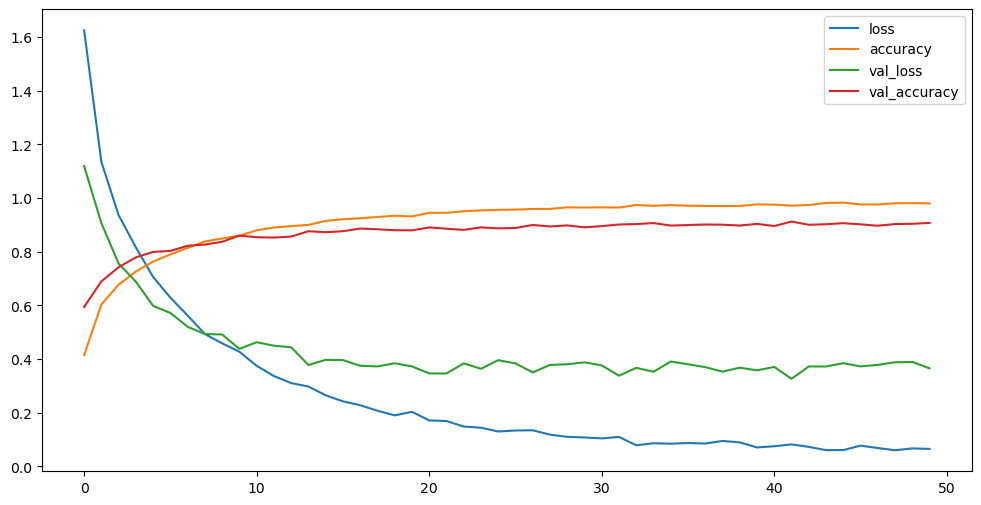

In [29]:
def plot_history(history):
    print("Validation Accuracy", max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

plot_history(model_hist)